In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
from pathlib import Path
from einops import rearrange, repeat
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

/mnt/ssd-2/spar/waree/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
num_hidden_layers = 40
layers_arr = np.arange(num_hidden_layers)

In [10]:
def load_and_stack_layers(num_layers: int, reporter_type: 'str', prefix_path: str) -> torch.Tensor:
    layers = []
    if reporter_type == 'lr' or reporter_type == 'lr2':
        for i in range(num_layers):
            layer_path = f"{prefix_path}/layer_{i}.pt"
            layer = torch.load(layer_path)
            layers.append(layer.linear.weight.detach().cpu())
        stacked = torch.cat(layers, dim=0)
        return stacked
    elif reporter_type == 'vinc':
        for i in range(num_layers):
            layer_path = f"{prefix_path}/layer_{i}.pt"
            layer = torch.load(layer_path)
            layers.append(layer.weight.detach().cpu())
        stacked = torch.cat(layers, dim=0)
        return stacked
    elif reporter_type == 'ccs':
        for i in range(num_layers):
            layer_path = f"{prefix_path}/layer_{i}.pt"
            layer = torch.load(layer_path)
            layers.append(layer.probe[0].weight.detach().cpu())
        stacked = torch.cat(layers, dim=0)
        return stacked

def get_norm_weights(data: dict, dataset: str, ccs_path: str, vinc_path: str, lr_path: str, lr2_path: str):
    
    #for reporter,path in zip(['ccs','vinc', 'lr', 'lr2'], [ccs_path,vinc_path,lr_path,lr2_path]):
    for reporter,path in zip(['ccs','vinc'], [ccs_path,vinc_path]):
        weights = load_and_stack_layers(num_hidden_layers, reporter, path)
        magnitude = torch.norm(weights, dim=-1, keepdim=True)
        data[(dataset, reporter)] = weights/magnitude
    

def similarity(rep1_normalized, rep2_normalized):
    cosine_sim = torch.einsum("ij,ij->i", rep1_normalized, rep2_normalized)
    return cosine_sim


def similarity_single_layer(rep1_normalized, rep1_layer: int, rep2_normalized):
    cosine_sim = torch.einsum("j,ij->i", rep1_normalized[rep1_layer], rep2_normalized)
    return cosine_sim

In [11]:
data = {}

for d in [1,5,10]:

    dataset = f"arith{d}"

    lr_path = f'/home/waree/elk-reporters/test-huggyllama/llama-13b/sethapun/arithmetic_2as_1to{d}/ccs/lr_models'
    ccs_path = f'/home/waree/elk-reporters/test-huggyllama/llama-13b/sethapun/arithmetic_2as_1to{d}/ccs/reporters'
    lr2_path = f'/home/waree/elk-reporters/test-huggyllama/llama-13b/sethapun/arithmetic_2as_1to{d}/vinc/lr_models'
    vinc_path = f'/home/waree/elk-reporters/test-huggyllama/llama-13b/sethapun/arithmetic_2as_1to{d}/vinc/reporters'

    get_norm_weights(data, dataset, ccs_path, vinc_path, lr_path, lr2_path)

In [31]:
sim = {}

for d in [1,5,10]:

    dataset = f"arith{d}"
    sim[(dataset, 'ccs-vinc')] = similarity(data[(dataset,'ccs')], data[(dataset,'vinc')])
    sim[(dataset, f'ccs-1-{d}')] = similarity(data[('arith1','ccs')], data[(dataset,'ccs')])
    sim[(dataset, f'vinc-1-{d}')] = similarity(data[('arith1','vinc')], data[(dataset,'vinc')])
    sim[(dataset, f'vinc-{d}-layer20')] = similarity_single_layer(data[(dataset,'vinc')],20,data[(dataset,'vinc')])
    sim[(dataset, f'ccs-{d}-layer20')] = similarity_single_layer(data[(dataset,'ccs')],20,data[(dataset,'ccs')])

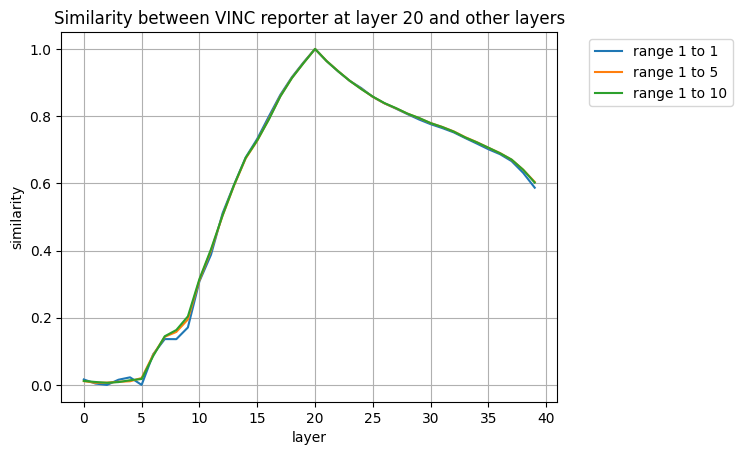

In [34]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity between VINC reporter at layer 20 and other layers")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [1,5,10]:

    dataset = f'arith{d}'
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'vinc-{d}-layer20')]), label = f"range 1 to {d}")

                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

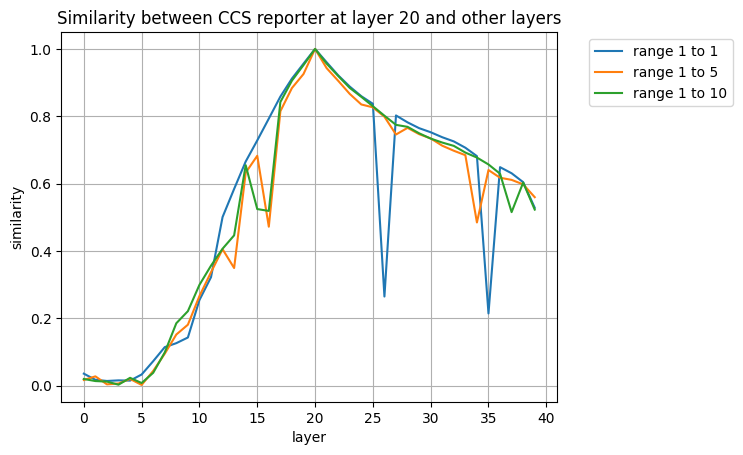

In [35]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity between CCS reporter at layer 20 and other layers")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [1,5,10]:

    dataset = f'arith{d}'
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'ccs-{d}-layer20')]), label = f"range 1 to {d}")

                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

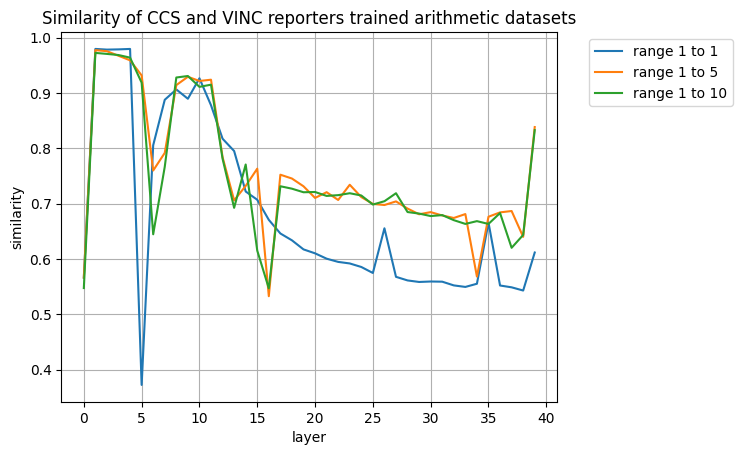

In [21]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity of CCS and VINC reporters trained arithmetic datasets")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [1,5,10]:

    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, 'ccs-vinc')]), label = f"range 1 to {d}")

                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

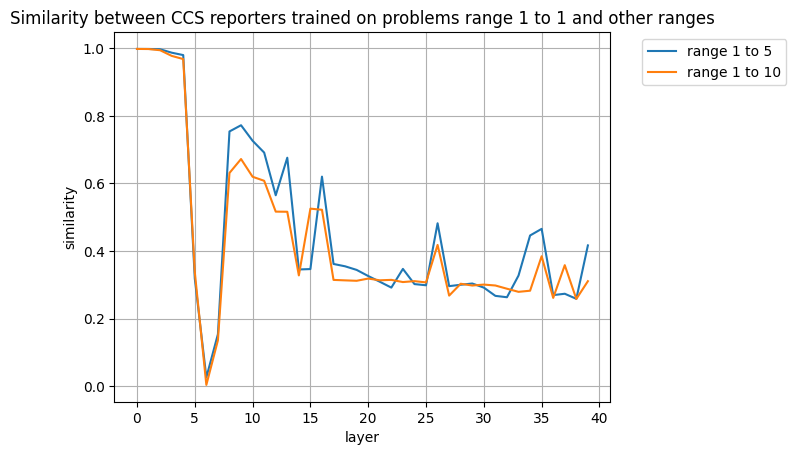

In [36]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity between CCS reporters trained on problems range 1 to 1 and other ranges")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [5,10]:
    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'ccs-1-{d}')]), label = f"range 1 to {d}")
                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

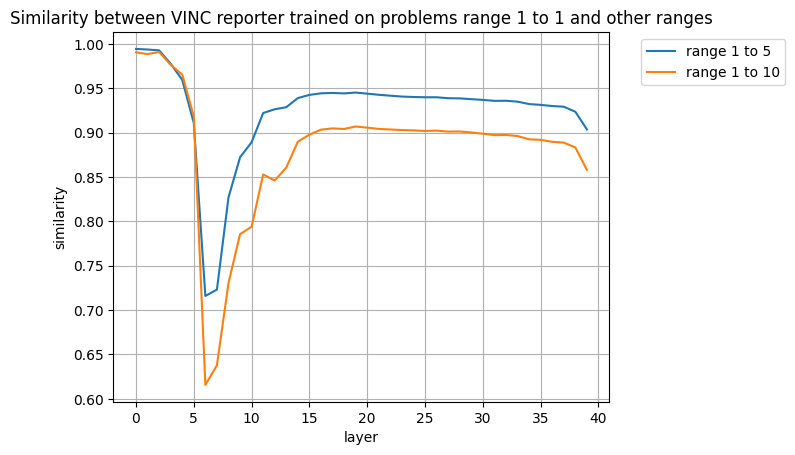

In [28]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity between VINC reporter trained on problems range 1 to 1 and other ranges")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [5,10]:
    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'vinc-1-{d}')]), label = f"range 1 to {d}")
                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()